## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [108]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Read in the dataset and take a look at the top few rows:

In [109]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset.

In [110]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [111]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [112]:
df.drop_duplicates('user_id').converted.mean()

0.11956955647936569

e. The number of times the `new_page` and `treatment` don't match.

In [113]:
(
df.query('group == "treatment" & landing_page == "old_page"').shape[0]
+ df.query('group == "control" & landing_page == "new_page"').shape[0]
)

3893

f. Do any of the rows have missing values?

In [114]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Create a new dataset with only the rows where new_page and treatment match.

In [115]:
df2 = df.query('(group == "treatment" & landing_page == "new_page") | (group == "control" & landing_page == "old_page")')
df2.shape

(290585, 5)

In [116]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [117]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [118]:
repeated_id = df2[df2.user_id.duplicated()].user_id.iat[0]
repeated_id

773192

c. What is the row information for the repeat **user_id**? 

In [119]:
df2.query('user_id == @repeated_id')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [120]:
df2 = df2.drop_duplicates(subset='user_id')
df2.shape

(290584, 5)

a. What is the probability of an individual converting regardless of the page they receive?

In [121]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [122]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [123]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [124]:
df2.landing_page.value_counts(normalize=True)['new_page']

0.50006194422266881

e. whether there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**No sufficient evidence that the new page leads to more conversions.**
>Results from above shows that both pages have about 12% of conversions which is not sufficient to conclude that the new page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?

**$$H_0: p_{new} - p_{old} <= 0$$**

**$$H_1: p_{new} - p_{old} > 0$$**

**$$\alpha = 0.05$$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Using a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [125]:
# under the null p_new & p_old are both equal to
# the converted success rate regardless of page 
# p_new = p_old = converted rate in ab_data.csv

p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [126]:
# same as above
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [127]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [128]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [129]:
# using numpy random binomial
# simulate choosing (1 or 0) single time with p_new rate
# for n_new times.

new_page_converted = np.random.binomial(1 , p_new, n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [130]:
# same as above with p_old & n_old values.

old_page_converted = np.random.binomial(1 , p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [131]:
# calculate difference in mean of two arrays

new_page_converted.mean() - old_page_converted.mean()

0.00040387555352854043

**$p_{new}$ - $p_{old}$ for simulated values is almost 0**

**as it should as $p_{new}$ & $p_{old}$ are the same under the null.**

**small difference caused by difference in $n_{new}$ & $n_{old}$**

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [132]:
# using numpy random binomial function
# simulate choosing (1 or 0) n_new time with p_new rate
# and sum the 1s in each for 10000 times
# then divid by n_new to get the avarage.

new_converted_10k = np.random.binomial(n_new, p_new, 10000) / n_new

In [133]:
# same as above with n_old & p_old

old_converted_10k = np.random.binomial(n_old, p_old, 10000) / n_old

In [134]:
p_diffs = new_converted_10k - old_converted_10k

In [135]:
p_diffs.shape

(10000,)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what we expected?

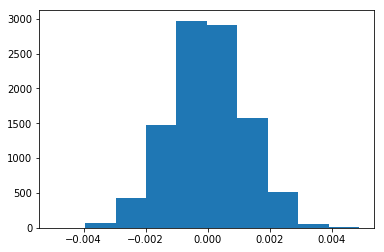

In [136]:
plt.hist(p_diffs);

**Yes, as expected the plot looks normally distributed "bell shaped" due to Central Limit Theorem**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [137]:
# calculate the actual mean of treatment group.
treatment_actual_mean = (df2.query('group == "treatment"')
                            .converted.mean())

# calculate the actual mean of control group.
control_actual_mean = (df2.query('group == "control"')
                        .converted.mean())

# calculate the actual difference observed.
observed_diff = treatment_actual_mean - control_actual_mean
observed_diff

-0.0015782389853555567

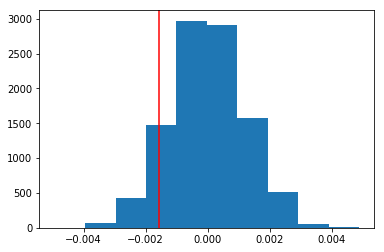

In [138]:
# visualize results
plt.hist(p_diffs);
plt.axvline(x=observed_diff, color='r');

In [139]:
p_diffs_greater = (p_diffs > observed_diff).mean()
print(f'proportion of the p_diffs are greater than the actual difference observed in ab_data.csv: {p_diffs_greater}')

proportion of the p_diffs are greater than the actual difference observed in ab_data.csv: 0.9073


k. Explain what we just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The p_value is the probability of the observed statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.**

**Our observed statistic here is the actual difference observed in dataset "observed_diff" and the alternative hypothesis is that the new page is better than the old page in conversion rate. $$p_{new} - p_{old} >= 0$$**

**Thus the proportion of simulated differences in conversion rates between the new and old pages "p_diffs" values which are greater than the actual difference observed in the dataset "observed_diff" is the P_value which is the area of the region to the right of the red line in the plot.**

**The P_value is large "about 0.9" and it is much bigger than Type I error rate "5%" which suggests we should not move away from the null hypothesis "The new page is worse, or only as good, as the old".**

<Center>P_value = 0.9
$$\alpha = 0.05$$

**In this case we fail to reject the null hypothesis, which means there is no difference between the new and old pages**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [140]:
import statsmodels.api as sm

convert_old = (df2.
               query('landing_page == "old_page" & converted == 1')
               .shape[0])
convert_new = (df2.
               query('landing_page == "new_page" & converted == 1')
               .shape[0])
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [141]:
# null hypothesis is P_new = p_old so value = 0
# p_old is p1 & p_new is p2
# alternative hypothesis is p_new > p_old (p2 > p1 or p1 < p2)
# alternative = 'smaller'

z_score, p_values = sm.stats.proportions_ztest(
    [convert_old, convert_new],
    [n_old, n_new],
    alternative='smaller'
)

z_score, p_values

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value we computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**p-value is the probability of the observed statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.**

**z-score measures standard deviations, very high or very low (negative) z-scores associated with very small p-values, are found in the tails of the normal distribution**

**Small p-values and either a very high or a very low z-score indicates that we could reject the null hypothesis.**

**In our case p-value is high & z-score is not very high nor very low, so we fail to reject the null hypothesis.**

**The p-value & z-score suggest that old page conversion rate is better or at least equal to the conversion rate of the new page.**

**Yes, z-score and p-value you computed in the previous question agree with the findings in parts j & k**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should we be performing in this case?

**Logistic regression should be used since we will be predicting a categorical value.**

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [142]:
df2.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


In [143]:
# add intercept column
df2['intercept'] = 1


# add ab_page column
# since we need only 1 column
# we could add it directly without using pd.get_dummies
df2['ab_page'] = (df2.group == 'treatment').astype(int)

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate the regression model on the two columns created in part b., then fit the model using the two columns  created in part **b.** to predict whether or not an individual converts. 

In [144]:
# instantiate logistic model
log_model = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])

# fit the model
result = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. The summary of the model.

In [145]:
# summary
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-06-07 11:26 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [146]:
# ab_page coefficient is negative
# take the reciprocal of coefficient exponentiated
1 / np.exp(result.params)

intercept    7.306593
ab_page      1.015102
dtype: float64

**The new page is 1.015 less likely to lead to more conversions holding all else constant.**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

**p-value associated with ab_page is 0.1899.**

**In regression the p-values are always given for testing if the parameter fo intercept or the slope is equal to zero which is the null hypothesis.**

> Null: parameter = 0

> Aleternative: parameter != 0

**These p-values can give a quick glimpse as wether or not a particular variable is useful for predicting the response.**

**p-value for ab_page here is 0.1899 which suggests that the new page is not statistically significant in relating to conversion.**

**p-values differ from Part II because in the A/B test our null hypothesis states that the old page is better than or equal to the new page "one-tailed test" but regression is a two-tailed test therefore p-values are a different.**

f. Now,considering other things that might influence whether or not an individual converts. Why it is a good idea to consider other factors to add into the regression model.  Are there any disadvantages to adding additional terms into the regression model?

**Considering our case scenario, there might be many other things influencing whether or not an individual converts, for example:**

>Change Aversion: Existing users may give an unfair advantage to the old page, simply because they are unhappy with change, even if it’s ultimately for the better.

>Novelty Effect: Existing users may give an unfair advantage to the new page, because they’re excited or drawn to the change, even if it isn’t any better in the long run.

>User gender might be influencing his/her decision, Male users might lean to convert from more one of the pages ore vice versa.

> User age might affect his decision, younger audience might be more attracted to the new page.

> The country or region of individuals also might influence his decision, one of the page might be more popular in some countries or some cultures.

**It might be a good idea to consider these factors to add into regression model**

**However, adding additional terms to our regression model might lead to some potential problems:**

>Multi-collinearity: Multicollinearity is when we have predictor variables that are correlated with one another. One of the main concerns of multicollinearity is that it can lead to coefficients being flipped from the direction we expect from simple linear regression. One of the most common ways to identify multicollinearity is with bivariate plots or with variance inflation factors (or VIFs).

>Linearity: The assumption of linearity is that a linear model is the relationship that truly exists between our response and predictor variables. If this isn't true, then our predictions will not be very accurate. Additionally, the linear relationships associated with our coefficients really aren't useful either.

>Outliers/Leverage Points : points that lie far away from the regular trends of our data. These points can have a large influence on our solution.

>Correlated Errors: Correlated errors frequently occur when our data are collected over time or data are spatially related.

>Non-constant Variance and Normally Distributed Errors: Non-constant variance is when the spread of our predicted values differs depending on which value we are trying to predict. This isn't a huge problem in terms of predicting well. However, it does lead to confidence intervals and p-values that are inaccurate.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. Read in the **countries.csv** dataset and merge together the datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion? 

**Reading and inspecting new dataset**

In [147]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [148]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


> 290584 rows, no null values

In [149]:
# count of unique users
countries.user_id.nunique(), df2.user_id.nunique()

(290584, 290584)

> all usere are unique & same count of user in df2

In [150]:
# unique country values
countries.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

> data collected from 3 countries

In [151]:
# add columns with dummy values for countries
dummies = pd.get_dummies(countries.country, drop_first=True)
countries = countries.join(dummies)
countries.head()

,user_id,country,UK,US
0,834778,UK,1,0
1,928468,US,0,1
2,822059,UK,1,0
3,711597,UK,1,0
4,710616,UK,1,0


**merging the two datasets**

In [152]:
# set index for both data frames to user_id for using in join
# how = inner to get the intersection of both data frames
df3 = countries.set_index('user_id').join(
    df2.set_index('user_id'), how='inner')

df3.head()

,country,UK,US,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,,,
834778,UK,1,0,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,0,1,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,1,0,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,1,0,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,1,0,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [153]:
df3.shape

(290584, 9)

In [154]:
# instantiate logistic model
log_model2 = sm.Logit(df3.converted, df3[['intercept', 'UK', 'US']])

# fit the model
result2 = log_model2.fit()
result2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-06-07 11:26 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

In [155]:
# Coef for both UK & US is greater than zero
np.exp(result2.params.iloc[1:])

UK    1.052027
US    1.041647
dtype: float64

**Compare to CA:**
<li>UK is  1.052 more likely to lead to more conversions holding all else constant</li>
<li>US is  1.042 more likely to lead to more conversions holding all else constant</li>

**p-values for UK= 0.0740 & US= 0.1291 which suggests neither of them has statistically significant in relating to conversion.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [156]:
# creat columns for interaction between country & ab_page.

df3['UK_ab_page'] = df3.UK * df3.ab_page
df3['US_ab_page'] = df3.US * df3.ab_page
df3.head()

,country,UK,US,timestamp,group,landing_page,converted,intercept,ab_page,UK_ab_page,US_ab_page
user_id,,,,,,,,,,,
834778,UK,1,0,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0
928468,US,0,1,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,1,0,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,1,0,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0
710616,UK,1,0,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [157]:
# instantiate logistic model with "higher & lower" odredr terms
log_model3 = sm.Logit(df3.converted, df3[['intercept', 'UK_ab_page', 'US_ab_page', 'US', 'UK', 'ab_page']])

#fit the model
result3 = log_model3.fit()

#show summary
result3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-06-07 11:26 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
==================================================================

"""

In [158]:
1 / np.exp(result3.params.iloc[[0,-1]])

intercept    7.418713
ab_page      1.069775
dtype: float64

In [159]:
np.exp(result3.params.iloc[1:-1])

UK_ab_page    1.081428
US_ab_page    1.048001
US            1.017682
UK            1.011854
dtype: float64

**Based on the result:**

**p-values are large which suggests neither of the variables has statistically significant in relating to conversion.**

**Interaction between page and country doesn't have significant effects on conversion**

**coefficients for ab_page, US, & UK in this model differ from the first model:**

<li>The new page is 1.07 less likely to lead to more conversions holding all else constant.</li>
<li>Compare to CA, UK is  1.012 more likely to lead to more conversions holding all else constant</li>
<li>Compare to CA, US is  1.018 more likely to lead to more conversions holding all else constant</li>
<li>Individuals in UK that land on the new page are 1.081 more likely to lead to more conversions holding all else constant</li>
<li>Individuals in US that land on the new page are 1.048 more likely to lead to more conversions holding all else constant</li>

In [107]:
CoeftionsCoeftionsfrom subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0